In [1]:
import os

import numpy as np
import cv2

import random

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.lines import Line2D

import seaborn as sns

from tqdm import tqdm

In [2]:
path_df = r'/Users/wlweert/Documents/hypothesis-writing/octopus-odor-guided-search/DATA/COMPARING_NOFOOD_W_ODOR/comb_dat-df.h5'
df = pd.read_hdf(path_df)
df.columns

Index(['seq-code', 'food-code', 'xy-in-food-pos', 'within-sequence-index',
       'x-position', 'y-position', 'dx', 'dy', 'x-bodyaxis-unitvector',
       'y-bodyaxis-unitvector', 'above-speed-threshold__mean-plus-std',
       'full-frame-reference__bodyaxis-angle', 'heading-offset-angle'],
      dtype='object')

In [3]:
path_flow_dir = r'/Users/wlweert/Documents/hypothesis-writing/octopus-odor-guided-search/flow-visualization/DATA/INTERMITANCY/'
path_mask = os.path.join(path_flow_dir, 'mask_10i_inter.png')
path_plume = os.path.join(path_flow_dir, 'bbox_nozzleheight_1in_100ke_30g_10fps_01.mp4')



In [4]:
target_dir = r'/Users/wlweert/Documents/hypothesis-writing/octopus-odor-guided-search/DATA/BODYAXIS_1T/'
wire_octopus = os.path.join(target_dir, 'centered_image.png')

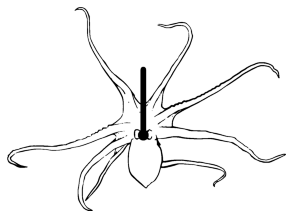

In [5]:
wire_octopus_img = cv2.imread(wire_octopus)
wire_octopus_img = cv2.cvtColor(wire_octopus_img, cv2.COLOR_RGB2GRAY)

x1 = int(wire_octopus_img.shape[1]/2)-15
y1 = int(wire_octopus_img.shape[0]/2)-120
pt1 = (x1, y1)
pt2 = (x1, y1+300)

wire_octopus_img = cv2.line(wire_octopus_img, pt1, pt2, 255, 25)
wire_octopus_img = cv2.circle(wire_octopus_img, pt1, 25, 255, -1)

wire_octopus_img = cv2.flip(wire_octopus_img, 0)

#rec, wire_octopus_img = cv2.threshold(wire_octopus_img, 1, 255, cv2.THRESH_BINARY)
wire_octopus_img = (wire_octopus_img > 1)*255


fig, (ax1) = plt.subplots(1,1,figsize=(5,5))

ax=ax1
ax.imshow(wire_octopus_img, cmap='Greys')
ax.set_xticks([])
ax.set_yticks([])

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show(fig)
plt.close(fig)

100%|█████████████████████████████████████| 1800/1800 [00:01<00:00, 1167.13it/s]


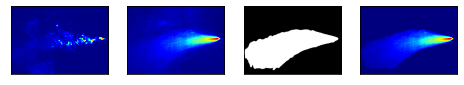

In [6]:
cap = cv2.VideoCapture(path_plume)
plume = []
l = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
pbar = tqdm(total = l, position=0, leave=True)
for i in range(0, l):
    success, img = cap.read()
    if success != True:
        print(i, 'failed to read video')
    else:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        plume.append(img)
    pbar.update(n=1)
pbar.close()
cap.release()
std_plume = np.std(plume, axis=0)

mask = cv2.imread(path_mask)
mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
mask = mask/np.max(mask)

masked_plume = mask*std_plume

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(8,4))

ax=ax1
ax.imshow(plume[1000], cmap='jet')
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

ax=ax2
ax.imshow(std_plume, cmap='jet')
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

ax=ax3
ax.imshow(mask, cmap='Greys_r')
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

ax=ax4
ax.imshow(masked_plume, cmap='jet')
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

plt.show(fig)
plt.close(fig)

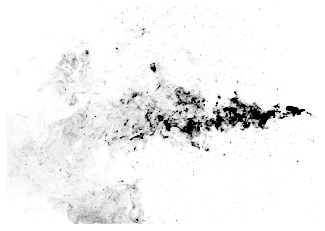

In [7]:
bg_img = plume[1000]

fig, (ax1) = plt.subplots(1,1,figsize=(8,4))

ax=ax1
ax.imshow(bg_img, cmap='Greys', vmin = 2, vmax=50)
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect('equal')

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show(fig)
plt.close(fig)

In [8]:
food = sorted(list(set(df['food-code'].tolist())))
food

['Food eaten - downstream',
 'Food eaten - upstream',
 'Food not eaten',
 'No food']

100%|███████████████████████████████████████████| 32/32 [00:05<00:00,  5.48it/s]


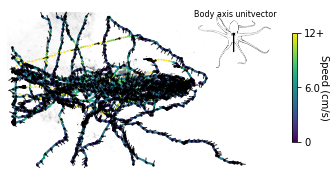

In [9]:
ss = 10
bar_scale = 20
dv_scale = 2

dfs = df[df['food-code'] == 'Food eaten - downstream']
seqs = sorted(list(set(dfs['seq-code'].tolist())))

S = (dfs['dx']**2 + dfs['dy']**2)**(1/2) 
S = (S/20*2.54) * 10 ## px/(px/in)*(cm/in) * fr/sec
Smax = round(3.5*np.std(S))

#norm = mpl.colors.Normalize(vmin = 0, vmax = Smax)
#cmap = cm.get_cmap('viridis')
#m = cm.ScalarMappable(norm=norm, cmap=cmap)

fig, (ax1) = plt.subplots(1,1,figsize=(6,4))
ax = ax1

max_l = 0
pbar = tqdm(total = len(seqs), position=0, leave=True)
for i, seq in enumerate(seqs[:]):
    dat = dfs[dfs['seq-code'] == seq]
    if i == 7:
        dat = dat.iloc[100:]
    if i == 28:
        dat = dat.iloc[700:]
    
    X = np.array(dat['x-position'].tolist())
    Y = np.array(dat['y-position'].tolist())
    S = (dat['dx']**2 + dat['dy']**2)**(1/2)
    #c = [m.to_rgba(s) for s in S]
    
    ax.plot(X,Y, color='black', linewidth=1, alpha=0.1, zorder=1)
    g = ax.scatter(X,Y, c=S, cmap='viridis', s=1, zorder=2, vmin = 0, vmax = Smax)
    if i == 0:
        cbar = fig.colorbar(g, ax=ax, shrink=0.5,
                         ticks = [0, Smax/2, Smax],
                           pad = 0)
        cbar.ax.set_yticklabels([0, Smax/2, str(Smax) + '+'])
        cbar.ax.set_ylabel('Speed (cm/s)', rotation=270)
        
    uX = dat['x-bodyaxis-unitvector'][::ss]
    uY = dat['y-bodyaxis-unitvector'][::ss]
    
    #dX = (X[1:]-X[:-1])[::ss]
    #dY = (Y[1:]-Y[:-1])[::ss]
    if len(X) > max_l:
        max_l = len(X)
    
    X = X[::ss]
    Y = Y[::ss]
    
    for x, y, ux, uy, in list(zip(X, Y, uX, uY, )):
        ax.plot([x, x+ux*bar_scale], 
                [y, y+uy*bar_scale], 
                color='black', linewidth=1, alpha=0.8, zorder=3)
        
        #ax.plot([x, x+dx*dv_scale], 
        #        [y, y+dy*dv_scale], 
        #        color='green', linewidth=1, alpha=1, zorder=4)
        ax.scatter(x,y,color='black',s=2, alpha=0.8, zorder=4)
    
    pbar.update(n=1)
pbar.close()

ax.set_xlim(375,1800)
ax.set_ylim(995,190)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

'''
legend_labels = ['Bodyaxis unitvector', ]
legend_lines = [Line2D([0], [0], color='black', lw=3),]
ax.legend(legend_lines, legend_labels, 
          loc = 'upper right', fontsize=10, frameon=False)
'''
#ax.set_title('Speed and bodyaxis during odor tracking')

im_x0 = 1330
im_x1 = im_x0 + wire_octopus_img.shape[1]/3.5
im_y0 = 230 
im_y1 = im_y0 + wire_octopus_img.shape[0]/3.5
im_extent = (im_x0, im_x1 , im_y0, im_y1)
ax.imshow(wire_octopus_img, cmap = 'Greys', extent=im_extent)
ax.text(im_x0-20, im_y0+10, 'Body axis unitvector', fontsize = 8)

im_x0 = 375 #+ bg_img.shape[1]
im_x1 = im_x0 + bg_img.shape[1]/1
im_y0 = 215 #+ bg_img.shape[0]
im_y1 = im_y0 + bg_img.shape[0]/1
im_extent = (im_x0, im_x1 , im_y0, im_y1)
ax.imshow(bg_img, cmap='Greys', alpha = 0.5,  vmin = 2, vmax=50, zorder=0, extent=im_extent)

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

#ax.set_title('Bait approaches', loc='left', pad=-10)

fig_name = 'BodyAxis-ReOrientation-1t__1tOrientation.png'
path_fig = os.path.join(target_dir, fig_name)
fig.savefig(path_fig, dpi=300)

plt.show(fig)
plt.close(fig)

100%|██████████████████████████████████████████| 32/32 [00:00<00:00, 484.51it/s]


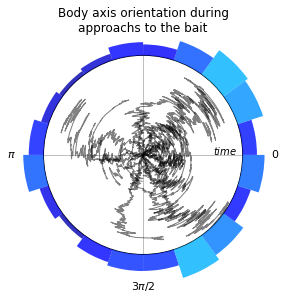

In [10]:
#https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python

#fig, (ax1) = plt.subplots(1,1,figsize=(4,4))


fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111, polar=True, )

dfs = df[df['food-code'] == 'Food eaten - downstream']
seqs = sorted(list(set(dfs['seq-code'].tolist())))

S = (dfs['dx']**2 + dfs['dy']**2)**(1/2) 
S = (S/20*2.54) * 10 ## px/(px/in)*(cm/in) * fr/sec
Smax = round(3.5*np.std(S))

thetas = []
radii = []
pbar = tqdm(total = len(seqs), position=0, leave=True)
for i, seq in enumerate(seqs[:]):
    dat = dfs[dfs['seq-code'] == seq]
    if i == 7:
        dat = dat.iloc[100:]
    if i == 28:
        dat = dat.iloc[700:]
    
    S = (dat['dx']**2 + dat['dy']**2)**(1/2)
    uX = dat['x-bodyaxis-unitvector']
    uY = dat['y-bodyaxis-unitvector']
    theta = np.arctan2(uY, uX).tolist()
    thetas = thetas + theta
    
    R = np.linspace(0, len(theta)/max_l, num=len(theta))
    ax.plot(theta,R, color='black', alpha=0.5, linewidth=1, zorder=2)
    
    ## convert unit vectors to theta and radii ##
    
    X = np.arange(0, len(uX))
    X = X + uX
    
    pbar.update(n=1)
pbar.close()

nbins = 20
bottom = 1

hist, bin_edges = np.histogram(thetas, bins = nbins, range = [-np.pi, np.pi], density=True) 
bins = [(i + j)/2 for i,j in list(zip(bin_edges[:-1], bin_edges[1:]))]

bars = ax.bar(bins, hist, width=(2*np.pi/nbins), bottom=1, zorder=3)

# Use custom colors and opacity
for r, bar in zip(hist, bars):
    bar.set_facecolor(plt.cm.jet(r))
    bar.set_alpha(0.8)

ax.set_rticks([])
ax.xaxis.grid([])
    
circle = plt.Circle((0,0), 1, 
                    transform=ax.transData._b, color="black", alpha=1, fill=False)
ax.add_artist(circle)
ax.spines['polar'].set_visible(False)
    
ax.set_xticks([0, np.pi, 1.5*np.pi])
ax.set_xticklabels([r'0', r'$\pi$',r'$3\pi/2$'], fontsize=11)
ax.tick_params(axis='x', which='major', pad=-15)

ax.set_title('Body axis orientation during\napproachs to the bait', pad=-13)

ax.plot([np.pi, np.pi], [0,1], zorder=0, color='black', linewidth=1, alpha=0.25)
ax.plot([np.pi/2, np.pi/2], [0,1], zorder=0, color='black', linewidth=1, alpha=0.25)
ax.plot([0,0], [0,1], zorder=0, color='black', linewidth=1, alpha=0.25)
ax.plot([np.pi*1.5, np.pi*1.5], [0,1], zorder=0, color='black', linewidth=1, alpha=0.25)

ax.text(0, .7, '$\it{time}$')

fig_name = 'BodyAxis-ReOrientation-1t__Polar1tOrientation.png'
path_fig = os.path.join(target_dir, fig_name)
fig.savefig(path_fig, dpi=300)

plt.show(fig)
plt.close(fig) 

100%|█████████████████████████████████████████| 397/397 [00:05<00:00, 75.43it/s]


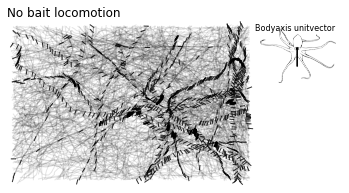

In [11]:
fig, (ax1) = plt.subplots(1,1,figsize=(6,4))
ax = ax1

dfs = df[df['food-code'] == 'No food']

seqs = sorted(list(set(dfs['seq-code'].tolist())))
animal_codes = sorted(list(set([s.split('-')[0] for s in seqs])))

nshow = 20
show_seqs_bold = random.sample(seqs, nshow)

#S = (dfs['dx']**2 + dfs['dy']**2)**(1/2) 
#S = (S/20*2.54) * 10 ## px/(px/in)*(cm/in) * fr/sec

muS = [0]*len(seqs)
pbar = tqdm(total = len(seqs), position=0, leave=True)
for i, seq in enumerate(seqs[:]):
    dat = dfs[dfs['seq-code'] == seq]
    
    X = np.array(dat['x-position'].tolist())
    Y = np.array(dat['y-position'].tolist())
    S = (dat['dx']**2 + dat['dy']**2)**(1/2) 
    S = (S/20*2.54) * 10 ## px/(px/in)*(cm/in) * fr/sec
    
    muS_tmp = np.mean(S)
    muS[i] = muS_tmp
    pbar.update(n=1)
pbar.close()
    
mu_muS = np.mean(muS)
std_muS = np.std(muS)
    
pbar = tqdm(total = len(seqs), position=0, leave=True)
for i, seq in enumerate(seqs[:]):
    dat = dfs[dfs['seq-code'] == seq]
    
    X = np.array(dat['x-position'].tolist())
    Y = np.array(dat['y-position'].tolist())
    S = (dat['dx']**2 + dat['dy']**2)**(1/2) 
    S = (S/20*2.54) * 10 ## px/(px/in)*(cm/in) * fr/sec
    
    if seq in show_seqs_bold:
        ax.plot(X,Y, color='black', linewidth=1, alpha=0.25, zorder=2)
    else:
        ax.plot(X,Y, color='black', linewidth=1, alpha=0.1, zorder=1)
        
    uX = dat['x-bodyaxis-unitvector'][::ss]
    uY = dat['y-bodyaxis-unitvector'][::ss]
    X = X[::ss]
    Y = Y[::ss]
    
    if seq in show_seqs_bold:
        for x, y, ux, uy, in list(zip(X, Y, uX, uY, )):
            ax.plot([x, x+ux*bar_scale], 
                    [y, y+uy*bar_scale], 
                    color='black', linewidth=1, alpha=0.8, zorder=3)
    
    pbar.update(n=1)
pbar.close()

ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlim(375,2000)
ax.set_ylim(995,190)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

im_x0 = 1600
im_x1 = im_x0 + wire_octopus_img.shape[1]/3.5
im_y0 = 230 
im_y1 = im_y0 + wire_octopus_img.shape[0]/3.5
im_extent = (im_x0, im_x1 , im_y0, im_y1)
ax.imshow(wire_octopus_img, cmap = 'Greys', extent=im_extent)
ax.text(im_x0-20, im_y0+10, 'Bodyaxis unitvector', fontsize = 8)

ax.set_title('No bait locomotion', loc='left', pad=-5)

fig_name = 'BodyAxis-ReOrientation-1t__NoFood-1tOrientation.png'
path_fig = os.path.join(target_dir, fig_name)
fig.savefig(path_fig, dpi=300)

plt.show(fig)
plt.close(fig)

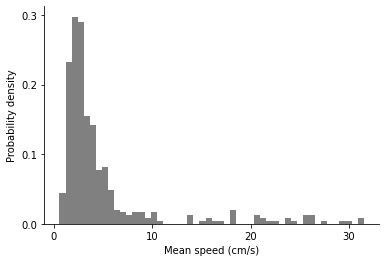

In [12]:
fig, (ax1) = plt.subplots(1,1,figsize=(6,4))

nbins = 50

ax=ax1
hist = ax.hist(muS, bins = nbins, density=True, zorder=1, color='grey')
dens, bin_edges = hist[0], hist[1]

bins = [(i+j)/2 for i, j in list(zip(bin_edges[:-1], bin_edges[1:]))]

ax.set_yticks([0, .1,.2, .3])
ax.set_xticks([0, 10, 20, 30])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel('Probability density')
ax.set_xlabel('Mean speed (cm/s)')

plt.show(fig)
plt.close(fig)

100%|█████████████████████████████████████████| 397/397 [00:04<00:00, 80.24it/s]


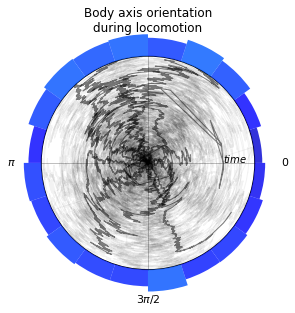

In [13]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111, polar=True, )

dfs = df[df['food-code'] == 'No food']
seqs = sorted(list(set(dfs['seq-code'].tolist())))

thetas = []
radii = []
pbar = tqdm(total = len(seqs), position=0, leave=True)
for i, seq in enumerate(seqs[:]):
    dat = dfs[dfs['seq-code'] == seq]
    if dat.shape[0] > max_l:
        dat = dat.iloc[:max_l]
    
    S = (dat['dx']**2 + dat['dy']**2)**(1/2)
    uX = dat['x-bodyaxis-unitvector']
    uY = dat['y-bodyaxis-unitvector']
    theta = np.arctan2(uY, uX).tolist()
    thetas = thetas + theta
    
    R = np.linspace(0, len(theta)/max_l, num=len(theta))
    if seq in show_seqs_bold:
        ax.plot(theta,R, color='black', alpha=0.5, linewidth=1, zorder=2)
    else:
        ax.plot(theta,R, color='black', alpha=0.05, linewidth=1, zorder=1)
    
    pbar.update(n=1)
pbar.close()

nbins = 20
bottom = 1

hist, bin_edges = np.histogram(thetas, bins = nbins, range = [-np.pi, np.pi], density=True) 
bins = [(i + j)/2 for i,j in list(zip(bin_edges[:-1], bin_edges[1:]))]

bars = ax.bar(bins, hist, width=(2*np.pi/nbins), bottom=1, zorder=3)


# Use custom colors and opacity
for r, bar in zip(hist, bars):
    bar.set_facecolor(plt.cm.jet(r))
    bar.set_alpha(0.8)

ax.set_rticks([])
ax.xaxis.grid([])
    
circle = plt.Circle((0,0), 1, 
                    transform=ax.transData._b, color="black", alpha=1, fill=False)
ax.add_artist(circle)
ax.spines['polar'].set_visible(False)
    
ax.set_xticks([0, np.pi, 1.5*np.pi])
ax.set_xticklabels([r'0', r'$\pi$',r'$3\pi/2$'], fontsize=11)
ax.tick_params(axis='x', which='major', pad=-10)

ax.set_title('Body axis orientation\nduring locomotion', pad=-5)

ax.plot([np.pi, np.pi], [0,1], zorder=0, color='black', linewidth=1, alpha=0.25)
ax.plot([np.pi/2, np.pi/2], [0,1], zorder=0, color='black', linewidth=1, alpha=0.25)
ax.plot([0,0], [0,1], zorder=0, color='black', linewidth=1, alpha=0.25)
ax.plot([np.pi*1.5, np.pi*1.5], [0,1], zorder=0, color='black', linewidth=1, alpha=0.25)

ax.text(0, .7, '$\it{time}$')

fig_name = 'BodyAxis-ReOrientation-1t__NoFood-Polar1tOrientation.png'
path_fig = os.path.join(target_dir, fig_name)
fig.savefig(path_fig, dpi=300)

plt.show(fig)
plt.close(fig)

In [14]:
S = (dfs['dx']**2 + dfs['dy']**2)**(1/2) 
S = (S/20*2.54) * 10 ## px/(px/in)*(cm/in) * fr/sec

df['Speed cm/s'] = S

IQRs = df['Speed cm/s'].describe([0.05,0.25,0.5,0.75,.95])
IQRs

count    250529.000000
mean          2.593849
std           3.957428
min           0.000000
5%            0.156987
25%           0.639566
50%           1.533701
75%           3.048400
95%           7.299937
max         120.949178
Name: Speed cm/s, dtype: float64

In [15]:
np.where(S == np.nan)

(array([], dtype=int64),)

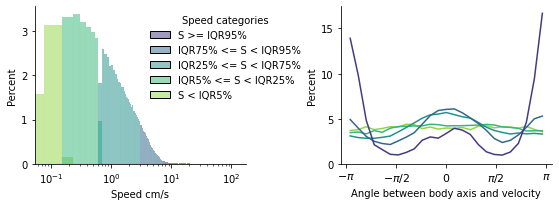

In [16]:
dat = df[(df['food-code'] == 'No food') | (df['food-code'] == 'Food eaten - downstream')] 
dat = dat.reset_index()

sc = {IQRs['5%']:'S < IQR5%', 
      IQRs['25%']: 'IQR5% <= S < IQR25%',
      IQRs['75%']: 'IQR25% <= S < IQR75%',
      IQRs['95%']: 'IQR75% <= S < IQR95%',
      'great':'S >= IQR95%'}
keys = list(sc.keys())
hue_order = [sc[s] for s in keys]
hue_order = list(reversed(hue_order))

s_cat = []
for i, s in enumerate(dat['Speed cm/s'].tolist()):
    if s < keys[0]:
        s_cat.append(sc[keys[0]])
    elif s >= keys[0] and s < keys[1]:
        s_cat.append(sc[keys[1]])
    elif s >= keys[1] and s < keys[2]:
        s_cat.append(sc[keys[2]])
    elif s >= keys[2] and s < keys[3]:
        s_cat.append(sc[keys[3]])
    elif s >= keys[3]:
        s_cat.append(sc['great'])
    else:
        s_cat.append(sc[keys[0]])
#s_cat.remove('')
dat['Speed categories'] = s_cat

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3))

ax=ax1
hist = sns.histplot(data=dat,
                     x = 'Speed cm/s',
                     stat='percent',
                     hue='Speed categories',
                     hue_order = hue_order,
                     palette='viridis',
                     legend=True,
                     #bins=2000,
                     ax=ax)
#ax.set_xlim(0,50)
ax.set_xscale('log')
sns.move_legend(hist, 'upper right', frameon=False, bbox_to_anchor=(1.3,1))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax=ax2
hist = sns.histplot(data=dat,
                     x ='heading-offset-angle',
                     stat='percent',
                     hue='Speed categories',
                     bins=25,
                     ax=ax,
                     multiple='layer',
                     common_norm=False,
                     hue_order = hue_order,
                     element='poly',
                     palette='viridis',
                     legend=False,
                     fill=False,
                   zorder=3)
#sns.move_legend(hist, 'upper center', frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'], fontsize=11)

ax.set_yticks([0, 5, 10, 15])

ax.set_xlabel('Angle between body axis and velocity')

fig.tight_layout(w_pad=0.5)
fig_name = 'BodyAxis-ReOrientation-1t__SpeedOrientationRelationship-1tOrientation.png'
path_fig = os.path.join(target_dir, fig_name)
fig.savefig(path_fig, dpi=300)

plt.show(fig)
plt.close(fig)

In [21]:
df.shape[0]/10/60/60

8.054555555555556